Loaded X: (456, 12, 7136, 3)
Loaded y: (456, 7136)
Grid points: 9620
Ocean-only points: 7136
Padding: 2484
X_2d shape: torch.Size([456, 12, 74, 130, 1])
Train: torch.Size([372, 12, 74, 130, 1])
Val: torch.Size([60, 12, 74, 130, 1])
Test: torch.Size([24, 12, 74, 130, 1])
Device: cpu
Epoch 1/50 | Train Loss=1.572704 | Val Loss=1.317517
Epoch 2/50 | Train Loss=1.013094 | Val Loss=0.791796
Epoch 3/50 | Train Loss=0.685322 | Val Loss=0.604377
Epoch 4/50 | Train Loss=0.571491 | Val Loss=0.528143
Epoch 5/50 | Train Loss=0.523901 | Val Loss=0.495140
Epoch 6/50 | Train Loss=0.497607 | Val Loss=0.476674
Epoch 7/50 | Train Loss=0.487635 | Val Loss=0.469405
Epoch 8/50 | Train Loss=0.481039 | Val Loss=0.463048
Epoch 9/50 | Train Loss=0.477226 | Val Loss=0.461311
Epoch 10/50 | Train Loss=0.474555 | Val Loss=0.460404
Epoch 11/50 | Train Loss=0.471836 | Val Loss=0.459884
Epoch 12/50 | Train Loss=0.471819 | Val Loss=0.460164
Epoch 13/50 | Train Loss=0.471208 | Val Loss=0.459450
Epoch 14/50 | Train Loss

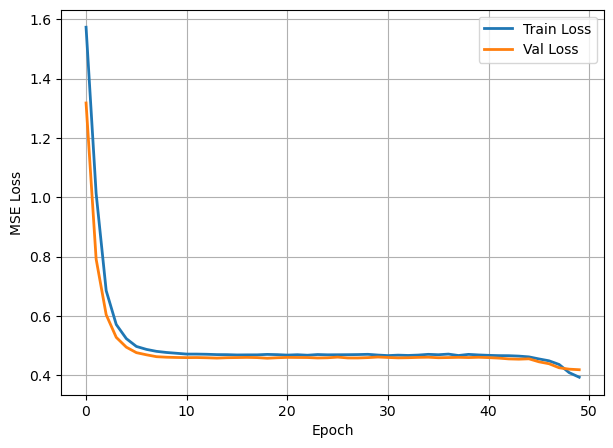

🔥 Test RMSE: 0.6599321


In [19]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# =====================================================
# 1. 加载处理好的数据
# =====================================================
data = np.load("LSTM_ocean_ready.npz")
X = data["X"]        # (456, 12, 7136, 3)
y = data["y"]        # (456, 7136)

print("Loaded X:", X.shape)
print("Loaded y:", y.shape)

# =====================================================
# 加载 ocean_idx 并构建 2D 网格 (74 × 130)
# =====================================================
ocean_idx = np.load("ocean_idx_7136.npy")   # (7136,)

H, W = 74, 130       # 2D CNN 输入网格
grid_size = H * W    # = 9620
pad_points = grid_size - len(ocean_idx)     # = 30

print("Grid points:", grid_size)
print("Ocean-only points:", len(ocean_idx))
print("Padding:", pad_points)

# 建立 2D mask
mask = np.zeros(grid_size, dtype=int)
mask[ocean_idx] = 1
mask = mask.reshape(H, W)

# =====================================================
# 2D 重建：将 ocean-only 数据填入 74 × 130 网格
# =====================================================
X_2d = np.zeros((456, 12, H, W, 3), dtype=np.float32)

flat = X_2d.reshape(456, 12, -1, 3)
flat[:, :, ocean_idx, :] = X
# ====== 选择单变量 ======
# 只用 SST
X_2d = X_2d[:, :, :, :, 0:1]

# 或者只用 dpCO2
# X_2d = X_2d[:, :, :, :, 1:2]

# 或者只用 Wind
# X_2d = X_2d[:, :, :, :, 2:3]
# ============================================

# 转换为 Tensor
X = torch.FloatTensor(X_2d)
y = torch.FloatTensor(y)

print("X_2d shape:", X.shape)   # (456,12,74,130,3)

# =====================================================
# 3. Train / Val / Test 划分
# =====================================================
train_end = 372
val_end = 372 + 60

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=8, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=8, shuffle=False)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# =====================================================
# 4. CNN Encoder + LSTM 模型
# =====================================================
class OceanCNN_LSTM(nn.Module):
    def __init__(self, H, W, hidden=128, layers=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((20, 20))  # 输出 64×20×20
        )

        self.flat_dim = 64 * 20 * 20  # 25600

        self.lstm = nn.LSTM(
            input_size=self.flat_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden, H * W)

    def forward(self, x):
        # x: (B,12,74,130,3)
        B, T, H, W, C = x.shape

        x = x.permute(0,1,4,2,3)  # (B,12,3,74,130)

        feats = []
        for t in range(T):
            ft = self.encoder(x[:, t])   # (B,64,20,20)
            ft = ft.reshape(B, -1)       # (B,25600)
            feats.append(ft)

        seq = torch.stack(feats, dim=1)  # (B,12,25600)

        out, _ = self.lstm(seq)
        last = out[:, -1, :]             # (B,128)

        y = self.fc(last)                # (B,9620)
        return y[:, :7136]               # 截取 ocean-only 7136 输出

# =====================================================
# 5. 初始化模型
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OceanCNN_LSTM(H, W).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Device:", device)

# =====================================================
# 6. 训练循环
# =====================================================
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        pred = model(Xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 验证集
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            val_loss += criterion(pred, yb).item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss={train_losses[-1]:.6f} | Val Loss={val_losses[-1]:.6f}")

# =====================================================
# 7. Loss 可视化
# =====================================================
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss", lw=2)
plt.plot(val_losses, label="Val Loss", lw=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.legend()
plt.show()

# =====================================================
# 8. 测试集 RMSE
# =====================================================
model.eval()
preds = []
trues = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        pred = model(Xb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

rmse = np.sqrt(np.mean((preds - trues)**2))
print("🔥 Test RMSE:", rmse)


In [25]:
print("mean:", X_train.mean())
print("min:", X_train.min())
print("max:", X_train.max())


mean: tensor(0.3594)
min: tensor(0.)
max: tensor(1.)


In [3]:
# =====================================================
# 8. 测试集 RMSE + R²
# =====================================================
model.eval()
preds = []
trues = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        pred = model(Xb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

# ---------- RMSE ----------
rmse = np.sqrt(np.mean((preds - trues)**2))
print("🔥 Test RMSE:", rmse)

# ---------- R² 计算 ----------
def compute_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

r2_score = compute_r2(trues, preds)
print(f"📈 Test R²: {r2_score:.4f}")

NameError: name 'model' is not defined

Loaded X: (456, 12, 7136, 3)
Loaded y: (456, 7136)
Grid points: 9620
Ocean-only points: 7136
Padding: 2484
X_2d shape: torch.Size([456, 12, 74, 130, 1])
Train: torch.Size([372, 12, 74, 130, 1])
Val: torch.Size([60, 12, 74, 130, 1])
Test: torch.Size([24, 12, 74, 130, 1])
Device: cpu
Epoch 1/50 | Train Loss=1.591636 | Val Loss=1.346011
Epoch 2/50 | Train Loss=1.042525 | Val Loss=0.802996
Epoch 3/50 | Train Loss=0.689862 | Val Loss=0.601864
Epoch 4/50 | Train Loss=0.572182 | Val Loss=0.525689
Epoch 5/50 | Train Loss=0.521810 | Val Loss=0.490988
Epoch 6/50 | Train Loss=0.497013 | Val Loss=0.477733
Epoch 7/50 | Train Loss=0.487062 | Val Loss=0.468611
Epoch 8/50 | Train Loss=0.480432 | Val Loss=0.463709
Epoch 9/50 | Train Loss=0.476863 | Val Loss=0.461422
Epoch 10/50 | Train Loss=0.473570 | Val Loss=0.459383
Epoch 11/50 | Train Loss=0.473647 | Val Loss=0.459883
Epoch 12/50 | Train Loss=0.471694 | Val Loss=0.460202
Epoch 13/50 | Train Loss=0.474955 | Val Loss=0.458260
Epoch 14/50 | Train Loss

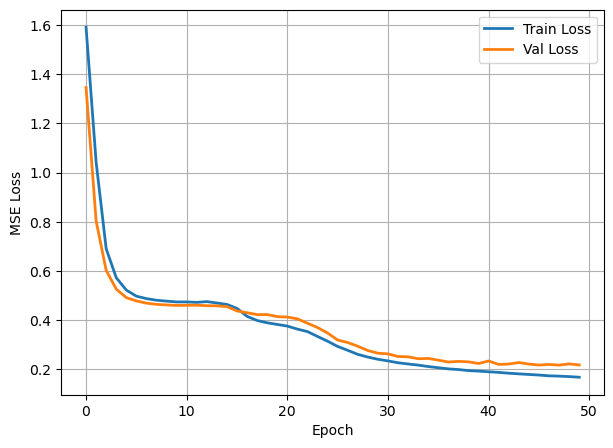

🔥 Test RMSE: 0.4607579


In [20]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# =====================================================
# 1. 加载处理好的数据
# =====================================================
data = np.load("LSTM_ocean_ready.npz")
X = data["X"]        # (456, 12, 7136, 3)
y = data["y"]        # (456, 7136)

print("Loaded X:", X.shape)
print("Loaded y:", y.shape)

# =====================================================
# 加载 ocean_idx 并构建 2D 网格 (74 × 130)
# =====================================================
ocean_idx = np.load("ocean_idx_7136.npy")   # (7136,)

H, W = 74, 130       # 2D CNN 输入网格
grid_size = H * W    # = 9620
pad_points = grid_size - len(ocean_idx)     # = 30

print("Grid points:", grid_size)
print("Ocean-only points:", len(ocean_idx))
print("Padding:", pad_points)

# 建立 2D mask
mask = np.zeros(grid_size, dtype=int)
mask[ocean_idx] = 1
mask = mask.reshape(H, W)

# =====================================================
# 2D 重建：将 ocean-only 数据填入 74 × 130 网格
# =====================================================
X_2d = np.zeros((456, 12, H, W, 3), dtype=np.float32)

flat = X_2d.reshape(456, 12, -1, 3)
flat[:, :, ocean_idx, :] = X
# ====== 选择单变量 ======
# 只用 SST
X_2d = X_2d[:, :, :, :, 1:2]

# 或者只用 dpCO2
# X_2d = X_2d[:, :, :, :, 1:2]

# 或者只用 Wind
# X_2d = X_2d[:, :, :, :, 2:3]
# ============================================

# 转换为 Tensor
X = torch.FloatTensor(X_2d)
y = torch.FloatTensor(y)

print("X_2d shape:", X.shape)   # (456,12,74,130,3)

# =====================================================
# 3. Train / Val / Test 划分
# =====================================================
train_end = 372
val_end = 372 + 60

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=8, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=8, shuffle=False)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# =====================================================
# 4. CNN Encoder + LSTM 模型
# =====================================================
class OceanCNN_LSTM(nn.Module):
    def __init__(self, H, W, hidden=128, layers=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((20, 20))  # 输出 64×20×20
        )

        self.flat_dim = 64 * 20 * 20  # 25600

        self.lstm = nn.LSTM(
            input_size=self.flat_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden, H * W)

    def forward(self, x):
        # x: (B,12,74,130,3)
        B, T, H, W, C = x.shape

        x = x.permute(0,1,4,2,3)  # (B,12,3,74,130)

        feats = []
        for t in range(T):
            ft = self.encoder(x[:, t])   # (B,64,20,20)
            ft = ft.reshape(B, -1)       # (B,25600)
            feats.append(ft)

        seq = torch.stack(feats, dim=1)  # (B,12,25600)

        out, _ = self.lstm(seq)
        last = out[:, -1, :]             # (B,128)

        y = self.fc(last)                # (B,9620)
        return y[:, :7136]               # 截取 ocean-only 7136 输出

# =====================================================
# 5. 初始化模型
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OceanCNN_LSTM(H, W).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Device:", device)

# =====================================================
# 6. 训练循环
# =====================================================
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        pred = model(Xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 验证集
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            val_loss += criterion(pred, yb).item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss={train_losses[-1]:.6f} | Val Loss={val_losses[-1]:.6f}")

# =====================================================
# 7. Loss 可视化
# =====================================================
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss", lw=2)
plt.plot(val_losses, label="Val Loss", lw=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.legend()
plt.show()

# =====================================================
# 8. 测试集 RMSE
# =====================================================
model.eval()
preds = []
trues = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        pred = model(Xb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

rmse = np.sqrt(np.mean((preds - trues)**2))
print("🔥 Test RMSE:", rmse)


In [24]:
print("mean:", X_train.mean())
print("min:", X_train.min())
print("max:", X_train.max())


mean: tensor(0.3594)
min: tensor(0.)
max: tensor(1.)


Loaded X: (456, 12, 7136, 3)
Loaded y: (456, 7136)
Grid points: 9620
Ocean-only points: 7136
Padding: 2484
X_2d shape: torch.Size([456, 12, 74, 130, 1])
Train: torch.Size([372, 12, 74, 130, 1])
Val: torch.Size([60, 12, 74, 130, 1])
Test: torch.Size([24, 12, 74, 130, 1])
Device: cpu
Epoch 1/50 | Train Loss=1.586348 | Val Loss=1.335444
Epoch 2/50 | Train Loss=1.030036 | Val Loss=0.791680
Epoch 3/50 | Train Loss=0.689883 | Val Loss=0.595921
Epoch 4/50 | Train Loss=0.568767 | Val Loss=0.521997
Epoch 5/50 | Train Loss=0.518977 | Val Loss=0.488923
Epoch 6/50 | Train Loss=0.495639 | Val Loss=0.475669
Epoch 7/50 | Train Loss=0.484882 | Val Loss=0.466876
Epoch 8/50 | Train Loss=0.480667 | Val Loss=0.462588
Epoch 9/50 | Train Loss=0.477255 | Val Loss=0.462790
Epoch 10/50 | Train Loss=0.474161 | Val Loss=0.458640
Epoch 11/50 | Train Loss=0.471267 | Val Loss=0.459305
Epoch 12/50 | Train Loss=0.470366 | Val Loss=0.458411
Epoch 13/50 | Train Loss=0.468863 | Val Loss=0.457568
Epoch 14/50 | Train Loss

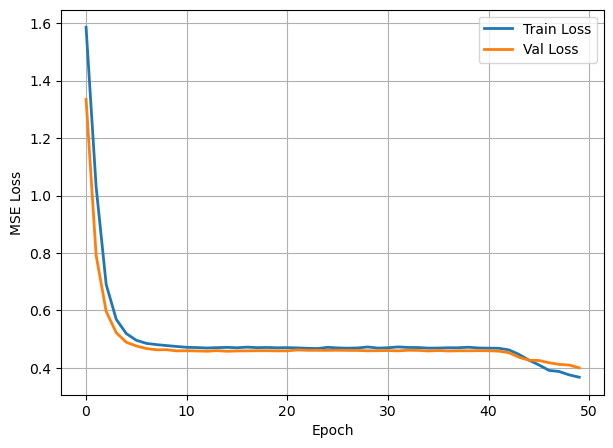

🔥 Test RMSE: 0.64275503


In [21]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# =====================================================
# 1. 加载处理好的数据
# =====================================================
data = np.load("LSTM_ocean_ready.npz")
X = data["X"]        # (456, 12, 7136, 3)
y = data["y"]        # (456, 7136)

print("Loaded X:", X.shape)
print("Loaded y:", y.shape)

# =====================================================
# 加载 ocean_idx 并构建 2D 网格 (74 × 130)
# =====================================================
ocean_idx = np.load("ocean_idx_7136.npy")   # (7136,)

H, W = 74, 130       # 2D CNN 输入网格
grid_size = H * W    # = 9620
pad_points = grid_size - len(ocean_idx)     # = 30

print("Grid points:", grid_size)
print("Ocean-only points:", len(ocean_idx))
print("Padding:", pad_points)

# 建立 2D mask
mask = np.zeros(grid_size, dtype=int)
mask[ocean_idx] = 1
mask = mask.reshape(H, W)

# =====================================================
# 2D 重建：将 ocean-only 数据填入 74 × 130 网格
# =====================================================
X_2d = np.zeros((456, 12, H, W, 3), dtype=np.float32)

flat = X_2d.reshape(456, 12, -1, 3)
flat[:, :, ocean_idx, :] = X
# ====== 选择单变量 ======
# 只用 SST
X_2d = X_2d[:, :, :, :, 2:3]

# 或者只用 dpCO2
# X_2d = X_2d[:, :, :, :, 1:2]

# 或者只用 Wind
# X_2d = X_2d[:, :, :, :, 2:3]
# ============================================

# 转换为 Tensor
X = torch.FloatTensor(X_2d)
y = torch.FloatTensor(y)

print("X_2d shape:", X.shape)   # (456,12,74,130,3)

# =====================================================
# 3. Train / Val / Test 划分
# =====================================================
train_end = 372
val_end = 372 + 60

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=8, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=8, shuffle=False)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# =====================================================
# 4. CNN Encoder + LSTM 模型
# =====================================================
class OceanCNN_LSTM(nn.Module):
    def __init__(self, H, W, hidden=128, layers=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((20, 20))  # 输出 64×20×20
        )

        self.flat_dim = 64 * 20 * 20  # 25600

        self.lstm = nn.LSTM(
            input_size=self.flat_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden, H * W)

    def forward(self, x):
        # x: (B,12,74,130,3)
        B, T, H, W, C = x.shape

        x = x.permute(0,1,4,2,3)  # (B,12,3,74,130)

        feats = []
        for t in range(T):
            ft = self.encoder(x[:, t])   # (B,64,20,20)
            ft = ft.reshape(B, -1)       # (B,25600)
            feats.append(ft)

        seq = torch.stack(feats, dim=1)  # (B,12,25600)

        out, _ = self.lstm(seq)
        last = out[:, -1, :]             # (B,128)

        y = self.fc(last)                # (B,9620)
        return y[:, :7136]               # 截取 ocean-only 7136 输出

# =====================================================
# 5. 初始化模型
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OceanCNN_LSTM(H, W).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Device:", device)

# =====================================================
# 6. 训练循环
# =====================================================
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        pred = model(Xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 验证集
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            val_loss += criterion(pred, yb).item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss={train_losses[-1]:.6f} | Val Loss={val_losses[-1]:.6f}")

# =====================================================
# 7. Loss 可视化
# =====================================================
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss", lw=2)
plt.plot(val_losses, label="Val Loss", lw=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.legend()
plt.show()

# =====================================================
# 8. 测试集 RMSE
# =====================================================
model.eval()
preds = []
trues = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        pred = model(Xb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

rmse = np.sqrt(np.mean((preds - trues)**2))
print("🔥 Test RMSE:", rmse)


In [23]:
print("mean:", X_train[0,0,:,:,:].mean())
print("min:", X_train[0,0,:,:,:].min())
print("max:", X_train[0,0,:,:,:].max())


mean: tensor(0.3342)
min: tensor(0.)
max: tensor(0.9316)
